<a href="https://colab.research.google.com/github/helainytorres/mapa/blob/main/Exemplo_LSTM_Embeding_sc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#imports
import numpy as np
import pandas as pd

**Teste de leitura de matriz esparsa**

In [1]:
pip install scanpy torch scipy numpy scikit-learn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 3.8 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=703d25c62961653763b604005eecc1b9ce8a2c57cfd92a58d2c5b847c827ee32
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [2]:
import scanpy as sc
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# **1. Carregar dados de expressão gênica com scanpy**
# Baixando um dataset público (ex.: PBMCs 3k células do 10x Genomics)
adata = sc.datasets.pbmc3k()

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

In [7]:
adata.var

,gene_ids
index,
MIR1302-10,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945
...,...
AC145205.1,ENSG00000215635
BAGE5,ENSG00000268590
CU459201.1,ENSG00000251180


In [34]:
#2700 celulas  x 32738 genes
#pegando apenas os 1000 genes mais representativos
adata.shape

(2700, 3000)

In [35]:
# Normalização básica e log-transformação
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


In [36]:
# Selecionando genes altamente variáveis
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
adata = adata[:, adata.var.highly_variable]

In [11]:
# Convertendo para matriz esparsa
sparse_matrix = adata.X

In [12]:
sparse_matrix.shape

(2700, 3000)

In [13]:
# **2. Pré-processamento**
# Normalizar os dados (caso necessário)
#dense_matrix = sparse_matrix.A if sparse_matrix.__class__.__name__ == 'csr_matrix' else sparse_matrix
dense_matrix = sparse_matrix.toarray()  # Use toarray() instead of .A

scaler = MinMaxScaler()
normalized_matrix = scaler.fit_transform(dense_matrix)

In [14]:
dense_matrix.shape

(2700, 3000)

In [14]:
dense_matrix


array([[0.       , 0.       , 0.       , ..., 4.646918 , 3.7449112,
        1.6352079],
       [0.       , 0.       , 1.1117153, ..., 4.508009 , 4.6922383,
        1.1117153],
       [0.       , 0.       , 1.4292607, ..., 3.1454134, 1.9948666,
        1.9948666],
       ...,
       [0.       , 0.       , 1.9370484, ..., 3.997176 , 3.2089453,
        0.       ],
       [0.       , 0.       , 0.       , ..., 4.772272 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 3.5908387, 0.       ,
        0.       ]], dtype=float32)

In [15]:
# Dividir os genes em sequências por célula
sequence_length = 3000  # Tamanho da sequência (número de genes por segmento)
sequences = [
    normalized_matrix[i, j:j+sequence_length]
    for i in range(normalized_matrix.shape[0])
    for j in range(0, normalized_matrix.shape[1], sequence_length)
]
sequences = np.array(sequences)

In [16]:
sequences.shape

(2700, 3000)

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,  Input # import the Input layer from keras.layers


In [18]:
# **3. Configuração do LSTM**
#     input_dim: Número de características na entrada (por exemplo, o número de genes em cada passo de tempo).
#     hidden_dim: Dimensão do estado oculto da LSTM.
#     num_layers: Número de camadas empilhadas na LSTM (permite que o modelo capture mais complexidade).
#     output_dim: Dimensão da saída final (por exemplo, número de classes ou dimensões do embedding).
class minhaLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(minhaLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)  # Remove redundant 'activation'
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Get the output and hidden state from the LSTM
        out, (hidden, _) = self.lstm(x)
        # Reshape the output to have batch size as the first dimension
        # Use out[:, -1] instead of out[:, -1, :] to get the output for the last time step.
        # This assumes that out has shape (batch_size, sequence_length, hidden_dim)
        # and you want the output at the last time step for each sequence in the batch.
        output = self.fc(out[:, :]) #Modified line to extract output from last time step
        return output

In [19]:
# Inicializando o modelo
input_dim = 3000   #sequence_length  # Dimensão da entrada (número de genes por segmento)
hidden_dim = 128  # Dimensão do espaço latente
num_layers = 2  # Número de camadas LSTM
output_dim = 32  # Dimensão do embedding final
model = minhaLSTM(input_dim, hidden_dim, num_layers, output_dim)

In [20]:
model

minhaLSTM(
  (lstm): LSTM(3000, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=32, bias=True)
)

In [21]:
# Convertendo os dados para PyTorch
sequences_tensor = torch.tensor(sequences, dtype=torch.float32)


In [22]:
sequences_tensor.shape

torch.Size([2700, 3000])

In [66]:
sequences_tensor.shape

torch.Size([2700, 1000])

In [23]:
# Passando os dados pelo modelo
embeddings = model(sequences_tensor)
print(f"Forma das embeddings: {embeddings.shape}")  # [n_amostras, output_dim]

# Reshape embeddings for KMeans if necessary
if embeddings.dim() == 1:
    embeddings = embeddings.reshape(-1, 1)  # Reshape to 2D if it's 1D

Forma das embeddings: torch.Size([2700, 32])


In [24]:
# **4. Clusterização**
# Aplicando K-Means nos embeddings gerados
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(embeddings.detach().numpy())

Interpretation

*   Range: The silhouette score ranges from -1 to +1.
*    High Score: A high silhouette score (closer to +1) indicates that the data point is well-matched to its own cluster and poorly matched to neighboring clusters. This means good clustering performance.
*   Low Score: A low silhouette score (closer to -1) indicates that the data point is poorly matched to its own cluster and may be better suited to a different cluster. This suggests potential issues with the clustering.
*    Score of 0: A silhouette score of 0 indicates that the data point is on or very close to the decision boundary between two neighboring clusters

In [28]:
# Avaliação com Silhouette Score
silhouette = silhouette_score(embeddings.detach().numpy(), clusters)
print(f"Silhouette Score: {silhouette:.2f}")

Silhouette Score: 0.07


In [26]:
!pip install yellowbrick

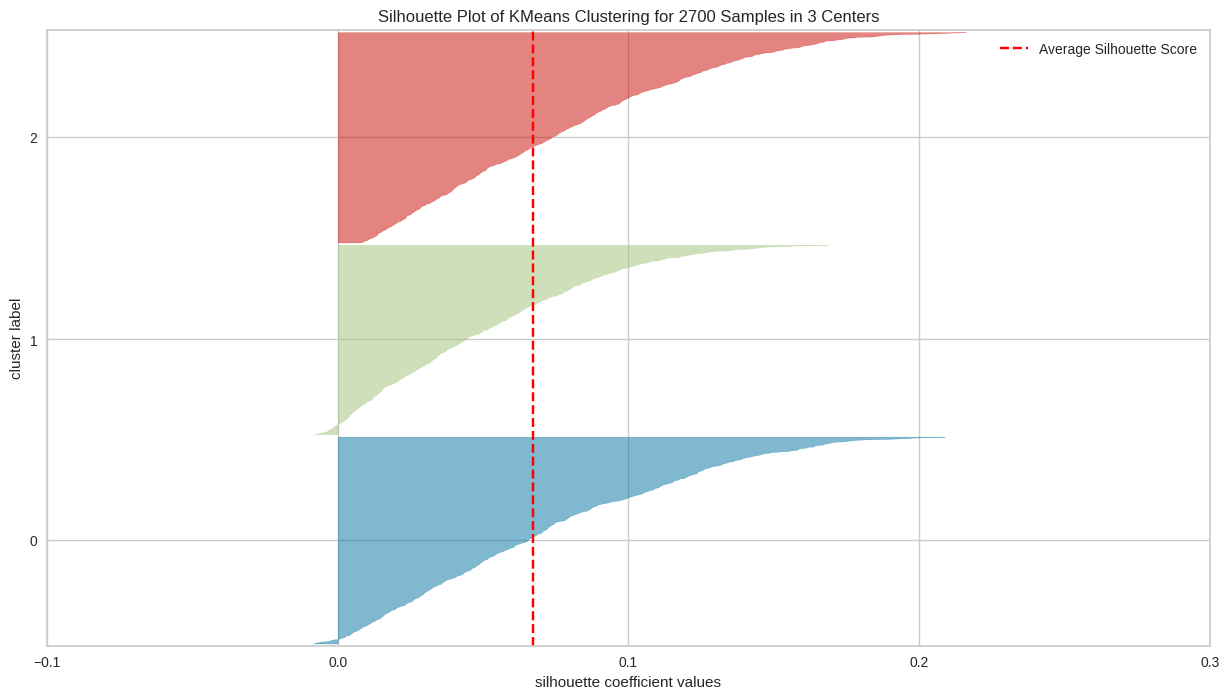

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 2700 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [27]:
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Create a SilhouetteVisualizer instance
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax)

# Fit the visualizer with the data and clusters
visualizer.fit(embeddings.detach().numpy())

# Display the silhouette plot
visualizer.show()

In [29]:
# Resultados
print(f"Clusters atribuídos: {clusters}")

Clusters atribuídos: [1 1 1 ... 1 1 1]


In [30]:
clusters.shape

(2700,)

In [31]:
# Adicionando clusters ao objeto AnnData
adata.obs['LSTM_Clusters'] = clusters

<ipython-input-31-6a274fec4e43>:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['LSTM_Clusters'] = clusters


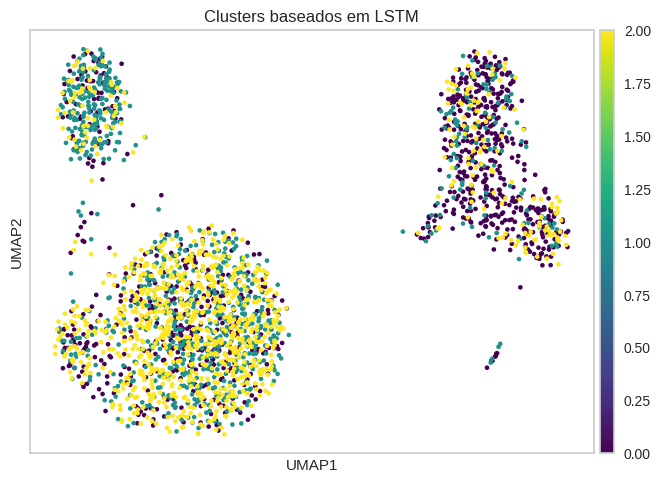

In [32]:
# **5. Visualização com Scanpy**
# UMAP com base nos clusters gerados
sc.pp.neighbors(adata, use_rep='X')  # Usa a matriz de expressão para calcular vizinhos
sc.tl.umap(adata)
sc.pl.umap(adata, color='LSTM_Clusters', title="Clusters baseados em LSTM", cmap='viridis')

# Other palette options:
# * 'Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Dark2', 'tab10', 'tab20', 'tab20b', 'tab20c'
# * 'viridis', 'plasma', 'inferno', 'magma', 'cividis'


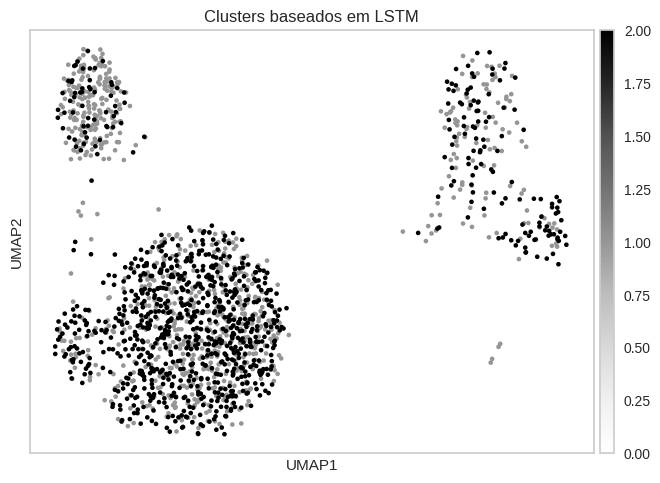

In [33]:
# prompt: como alterar a escalar de cor do umap gerado

# ... (Your existing code)

# **5. Visualização com Scanpy**
# UMAP com base nos clusters gerados
sc.pp.neighbors(adata, use_rep='X')  # Usa a matriz de expressão para calcular vizinhos
sc.tl.umap(adata)

# Alterando a escala de cores do UMAP
sc.pl.umap(adata, color='LSTM_Clusters', title="Clusters baseados em LSTM", palette=sc.pl.palettes.vega_20) # Example palette
# or any other matplotlib colormap
# sc.pl.umap(adata, color='LSTM_Clusters', title="Clusters baseados em LSTM", cmap='viridis')


# Other palette options:
# * 'Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Dark2', 'tab10', 'tab20', 'tab20b', 'tab20c'
# * 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
# * You can also define your own custom color palettes.  See the documentation for details.


View of AnnData object with n_obs × n_vars = 2700 × 1000
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'